# 1. Récupération des données

## a) Récupération des tweets postés par les clients 

In [18]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import kernel_ridge
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import csv
warnings.filterwarnings('ignore')
sns.set()

missing_values = ["na", "n/a", "--", " "]
data_df = pd.read_csv('tweet_100000.csv',
                      encoding='latin',
                      delimiter=",")


In [19]:
data_df.head()

,sentiment,id,date,query,user,tweet
0,0,2214557997,Wed Jun 17 16:54:53 PDT 2009,NO_QUERY,katierech21,just ateeee. so tired
1,0,2203600066,Wed Jun 17 00:06:07 PDT 2009,NO_QUERY,SomersetBob,@Claire_Cordon Oh! That's odd. Mine's always b...
2,0,2245264644,Fri Jun 19 15:53:21 PDT 2009,NO_QUERY,amhicks01,Lost my phone...This means I about to get some...
3,0,1992065737,Mon Jun 01 08:08:28 PDT 2009,NO_QUERY,zenjar,"Why do I always feel tired, I sleep more than ..."
4,0,2258718810,Sat Jun 20 16:23:03 PDT 2009,NO_QUERY,rosoco,thinkin bout goin to the improv tonite to go s...


In [20]:
data_df['sentiment'].value_counts()

4    50000
0    50000
Name: sentiment, dtype: int64

In [21]:
data_df['sentiment'] = data_df['sentiment'].map({0:'negative',
                                                 4:'positive'})

* On sélectionne un échantillon de 500 tweets positifs et de 500 tweets négatifs : 

In [22]:
data_df_pos = data_df[data_df["sentiment"] == 'positive'].sample(500)
data_df_neg = data_df[data_df["sentiment"] == 'negative'].sample(500)
data_df_new = data_df_pos.merge(data_df_neg, how='outer')

## b) Affichage des colonnes et lignes, ansi que leurs nombres


In [23]:
print('Nombre de restaurants dans le fichier   : ', data_df_new.shape[0])
print('Nombre de colonnes du fichier           : ', data_df_new.shape[1])

Nombre de restaurants dans le fichier   :  1000
Nombre de colonnes du fichier           :  6


In [24]:
nb_col_nan = data_df_new.isnull().sum()
nb_col_nan

sentiment    0
id           0
date         0
query        0
user         0
tweet        0
dtype: int64

* Chargement des tweets dans une liste :

In [8]:
tweets = []

for i in data_df_new.index:
    tweets.append(data_df_new["tweet"][i].strip())


In [9]:
tweets[0]

"wow what a night! had a blast with my best friend Valentina last night in the concert! i'll put some pictures here later..."

## b) Utilisation de l'API pour l'analyse de sentiment de Microsoft Azure

> On envoie de requêtes au service cognitif Azure d'analyse du sentiment pour obtenir le sentiment positif ou négatif d'un tweet.

In [12]:
import os
import requests
import uuid
import json
from dotenv import load_dotenv
load_dotenv()

key1_var_name     = 'COGNITIVE_SERVICE_KEY'
key2_var_name     = 'COGNITIVE_SERVICE_REGION'
endpoint_var_name = 'ANALYTICS_TEXT_ENDPOINT'


if not key1_var_name in os.environ:
    raise Exception('Please set/export the environment variable 1: {}'.format(key1_var_name))
subscription_key = os.environ[key1_var_name]

if not key2_var_name in os.environ:
    raise Exception('Please set/export the environment variable 2: {}'.format(key2_var_name))
region_key = os.environ[key2_var_name]


if not endpoint_var_name in os.environ:
    raise Exception('Please set/export the environment variable 3: {}'.format(endpoint_var_name))
endpoint = os.environ[endpoint_var_name]

path = 'text/analytics/v3.0/sentiment'
constructed_url = endpoint + path

headers = {
    'Ocp-Apim-Subscription-Key': subscription_key,
    'Ocp-Apim-Subscription-Region': region_key,    
    'Content-type': 'application/json',
    'X-ClientTraceId': str(uuid.uuid4())
}
taux_success  = []
    

def detectLang(*param):
    positive_succ     = 0
    negative_succ     = 0
    i = 0
    for elt in param:
        body = {
                "documents": [
                    {
                      "language": "en",
                      "id": i,
                      "text": elt
                    }
                              ]
                }
        request  = requests.post(constructed_url, headers=headers, json=body)
        response = request.json()
        id = response['documents'][0]['id']
        sentiment = response['documents'][0]['sentiment']
        sc = response['documents'][0]['confidenceScores']
        if i <= 5:
            print("Le texte :'{}' a le sentiment : '{}'\
                  avec un score de : '{}'".format(elt, sentiment, sc))
        if sentiment == data_df_new["sentiment"][i] and sentiment == 'negative':
            negative_succ += 1
        
        if sentiment == data_df_new["sentiment"][i] and sentiment == 'positive':
            positive_succ += 1
        i += 1
    
    tx_succ_neg = negative_succ / 500 * 100
    tx_succ_pos = positive_succ / 500 * 100
    taux_success.append(tx_succ_neg)
    taux_success.append(tx_succ_pos)



    
        
detectLang(*tweets)


Le texte :'wow what a night! had a blast with my best friend Valentina last night in the concert! i'll put some pictures here later...' a le sentiment : 'positive'                  avec un score de : '{'positive': 1.0, 'neutral': 0.0, 'negative': 0.0}'
Le texte :'@nipponcinema that looks pretty funny and interesting, lots of good actors too' a le sentiment : 'positive'                  avec un score de : '{'positive': 1.0, 'neutral': 0.0, 'negative': 0.0}'
Le texte :'Damn shame! It sucks bein a woman...All kinds of pains (c) @Anesidora as she soaks her feet! &lt;--  I just smile...beauty is PAIN! FACT!' a le sentiment : 'mixed'                  avec un score de : '{'positive': 0.31, 'neutral': 0.0, 'negative': 0.69}'
Le texte :'Morning Twitter' a le sentiment : 'neutral'                  avec un score de : '{'positive': 0.05, 'neutral': 0.93, 'negative': 0.02}'
Le texte :'uploading pics from Graduation. Tomorrow, family cookout' a le sentiment : 'positive'                  avec un scor

In [13]:
print(taux_success)

[46.0, 53.800000000000004]


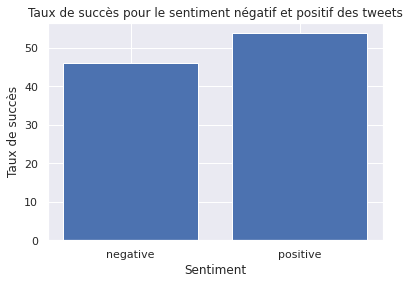

In [14]:
sent  = ['negative','positive']
xs = [ i + 0.1 for i, _ in enumerate (sent)]

plt.bar (xs,taux_success)
plt.title ("Taux de succès pour le sentiment négatif et positif des tweets")
plt.ylabel ("Taux de succès")
plt.xlabel ("Sentiment")
plt.xticks([ i + 0.1 for i, _ in enumerate (sent)],sent)
plt.show() 